In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import gamma
import scipy.special

%matplotlib inline

## Derive analytical posterior with a Gamma prior, then train a MDN to approximate it

Assuming $x \sim Poisson(\lambda)$ and $\lambda \sim Gamma(\alpha, \beta)$ we have for a single sample $x_i$ 

$$
p(x_i | \lambda) = \frac{y^{x_i} e^{-\lambda}}{x_i !}
$$

and for a vector $x$ of $N$ samples 

$$
p(x | \lambda) = \frac{\lambda^{\sum_{i=1}^N x_i} e^{-\lambda N}}{\prod_{i=1}^{N} x_i !}
$$

The prior is given by 

$$
p(\lambda | \alpha, \beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \lambda^{\alpha - 1}e^{-\beta \lambda}.
$$

Then the posterior over $\lambda$ given the observed data $x$ is given by 

$$
p(\lambda | x) \sim p(x | \lambda) p(\lambda) = \frac{\lambda^{\sum_{i=1}^N x_i} e^{-\lambda N}}{\prod_{i=1}^{N} x_i !} 
 \frac{\beta^{\alpha}}{\Gamma(\alpha)} \lambda^{\alpha - 1}e^{-\beta \lambda} 
\\ = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \frac{1}{\prod_{i=1}^{N} x_i !} \lambda^{\sum_{i=1}^N x_i + \alpha - 1} e^{-\lambda(N + \beta)}
$$

The posterior can be normalized by dividing it by the evidence. 

## Generate Poisson data

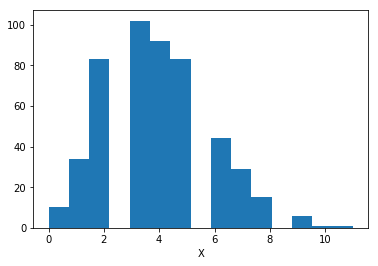

In [2]:
N = 500 # size of toy data
shape = 9. 
scale = .5
true_lam = 4.

X_o = np.random.poisson(lam=true_lam, size=N)

X_var = Variable(torch.Tensor(X_o.astype(float)))

plt.hist(X_o, bins='auto');
plt.xlabel('X');

## Use a MDN to learn the posterior over the mean of the Poisson model

In [3]:
class MDN_phi(nn.Module):
    def __init__(self, ndim_input=1, ndim_output=1, n_hidden=5, n_components=1):
        super(MDN_phi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.scale_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())
        self.shape_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_shape = self.scale_out(act)
        out_scale = self.shape_out(act)
        return (out_shape, out_scale)

# the loss evaluates model (MoG) with the given data (y) and takes the log loss
def mdn_loss_function(out_shape, out_scale, y):
    result = gamma_pdf(y, out_shape, out_scale, log=True)
    result = torch.mean(result)  # mean over batch
    return -result

def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys
        
def train(X, Y, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_shape, out_scale) = model(x_var)
            loss = mdn_loss_function(out_shape, out_scale, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))

In [4]:
# magical gammaln fun from pyro 
def log_gamma(xx):
    gamma_coeff = [
        76.18009172947146,
        -86.50532032941677,
        24.01409824083091,
        -1.231739572450155,
        0.1208650973866179e-2,
        -0.5395239384953e-5,
    ]
    magic1 = 1.000000000190015
    magic2 = 2.5066282746310005
    x = xx - 1.0
    t = x + 5.5
    t = t - (x + 0.5) * torch.log(t)
    ser = Variable(torch.ones(x.size()) * magic1)
    for c in gamma_coeff:
        x = x + 1.0
        ser = ser + torch.pow(x / c, -1)
    return torch.log(ser * magic2) - t

def gamma_pdf(x, shape, scale, log=False): 
    alpha = shape
    beta = 1 / scale
    
    ll_1 = -beta * x
    ll_2 = (alpha - 1.0) * torch.log(x)
    ll_3 = alpha * torch.log(beta)
    ll_4 = -log_gamma(alpha)
    result = torch.sum(ll_1 + ll_2 + ll_3 + ll_4, -1)
    if log:
        return result
    else: 
        return torch.exp(result)
    
def posterior_analytical(lam, x, alpha, beta, log=True):
    result = alpha * np.log(beta) - scipy.special.gammaln(alpha) - np.sum(scipy.special.gammaln(x + 1)) + (np.sum(x) + alpha -1)*np.log(lam) - lam * (x.size + beta)
    return result if log else np.exp(result)

def poisson_evidence(x, a, b): 
    x_sum = np.sum(x)
    log_xfac = np.sum(scipy.special.gammaln(x + 1))
    
    return a * np.log(b) - scipy.special.gammaln(a) - log_xfac + scipy.special.gammaln(a + x_sum) - (a + x_sum)*np.log(b + x.size)    

In [5]:
# we need to define a generative model to generate samples (theta, x)
def generate_dataset(N, m):
    # N data sets 
    # each with m samples 
    
    X = []
    thetas = []
    
    for i in range(N): 
        # sample from the prior 
        lam = np.random.gamma(shape, scale)

        # generate samples
        x = np.random.poisson(lam=lam, size=m)
        
        # as data we append the summary stats
        X.append(calculate_stats(x).astype(float)) 
        thetas.append([lam])
    
    return X, np.array(thetas)

# calculate summary stats, for poisson this is just x, so for a vector it is sum x
def calculate_stats(x): 
    sx = np.array([np.mean(x)])
    #sx = x
    return sx

In [6]:
model = MDN_phi(ndim_input=1, n_components=1)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
X, Y = generate_dataset(1000, N)

In [8]:
train(X, Y, n_epochs=2000)

[epoch 0050] loss: 0.8989
[epoch 0100] loss: 0.5934
[epoch 0150] loss: 0.4217
[epoch 0200] loss: 0.2483
[epoch 0250] loss: 0.0671
[epoch 0300] loss: 0.1053
[epoch 0350] loss: -0.0147
[epoch 0400] loss: 0.0035
[epoch 0450] loss: -0.1033
[epoch 0500] loss: -0.1859
[epoch 0550] loss: -0.1909
[epoch 0600] loss: -0.2609
[epoch 0650] loss: -0.2862
[epoch 0700] loss: -0.2547
[epoch 0750] loss: -0.2777
[epoch 0800] loss: -0.2654
[epoch 0850] loss: -0.3351
[epoch 0900] loss: -0.3494
[epoch 0950] loss: -0.3735
[epoch 1000] loss: -0.3352
[epoch 1050] loss: -0.3420
[epoch 1100] loss: -0.3628
[epoch 1150] loss: -0.3967
[epoch 1200] loss: -0.4015
[epoch 1250] loss: -0.4625
[epoch 1300] loss: -0.3486
[epoch 1350] loss: -0.3120
[epoch 1400] loss: -0.4053
[epoch 1450] loss: -0.4132
[epoch 1500] loss: -0.3664
[epoch 1550] loss: -0.5062
[epoch 1600] loss: -0.5656
[epoch 1650] loss: -0.4493
[epoch 1700] loss: -0.4659
[epoch 1750] loss: -0.4561
[epoch 1800] loss: -0.5000
[epoch 1850] loss: -0.5367
[epoch 1

In [9]:
# now evaluate the model at the observed data 
stats_o = np.array(calculate_stats(X_o).astype(float)).reshape(1, 1)

X_var = Variable(torch.Tensor(stats_o))

(out_shape, out_scale) = model(X_var)

In [10]:
n_thetas = 100
thetas = np.linspace(2, 6, n_thetas)

# make sure all variabel have dimensions (N, 1)
out_shapes = Variable(torch.Tensor(out_shape.data * torch.ones(thetas.size))).view(n_thetas, 1)
out_scales = Variable(torch.Tensor(out_scale.data * torch.ones(thetas.size))).view(n_thetas, 1)

prior_shapes = Variable(torch.Tensor(shape * torch.ones(thetas.size))).view(n_thetas, 1)
prior_scales = Variable(torch.Tensor(scale * torch.ones(thetas.size))).view(n_thetas, 1)

post = gamma_pdf(Variable(torch.Tensor(thetas.reshape(n_thetas, 1))), out_shapes, out_scales, log=False).data.numpy()

prior = gamma_pdf(Variable(torch.Tensor(thetas.reshape(n_thetas, 1))), prior_shapes, prior_scales, log=False).data.numpy()

In [11]:
# get true posterior 

# first calculate the normalization factor, use log for stability
alpha = shape 
beta = 1 / scale
evidence = poisson_evidence(X_o, alpha, beta)

# the the normalized posterior 
true_post = posterior_analytical(thetas, X_o, alpha, beta, log=True) - evidence

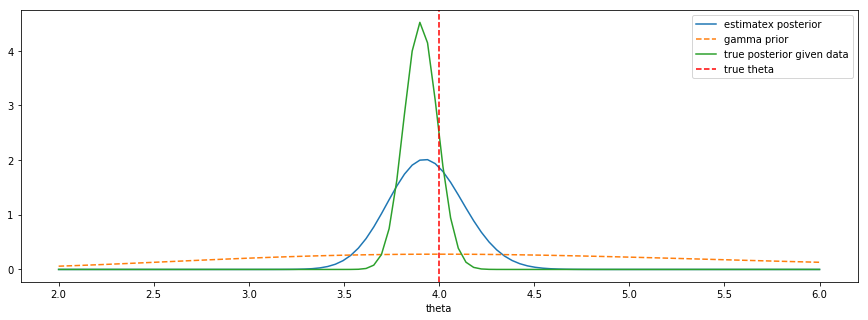

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(thetas, post, label='estimatex posterior')
plt.plot(thetas, prior, '--', label='gamma prior')
plt.plot(thetas, np.exp(true_post), label='true posterior given data')
plt.axvline(x=true_lam, label='true theta', linestyle='--', color='r')
plt.xlabel('theta')
plt.legend();